# Bayesian AlexNet performance metrics on MNIST

[2] *Shridhar, Kumar, Felix Laumann, and Marcus Liwicki. "A Comprehensive Guide to Bayesian Convolutional Neural Network with Variational Inference." arXiv preprint arXiv:1901.02731, 2019.*


In [1]:
!git clone https://github.com/kumar-shridhar/PyTorch-BayesianCNN.git

# @article{shridhar2019comprehensive,
#   title={A comprehensive guide to bayesian convolutional neural network with variational inference},
#   author={Shridhar, Kumar and Laumann, Felix and Liwicki, Marcus},
#   journal={arXiv preprint arXiv:1901.02731},
#   year={2019}
# }

Cloning into 'PyTorch-BayesianCNN'...
remote: Enumerating objects: 384, done.
remote: Counting objects: 100% (384/384), done.
remote: Compressing objects: 100% (222/222), done.
remote: Total 1375 (delta 220), reused 314 (delta 154), pack-reused 991
Receiving objects: 100% (1375/1375), 67.75 MiB | 23.18 MiB/s, done.
Resolving deltas: 100% (821/821), done.


In [1]:

%cd PyTorch-BayesianCNN
!ls

/content/PyTorch-BayesianCNN
config_bayesian.py     layers		    models
config_frequentist.py  LICENSE		    README.md
data		       main_bayesian.py     tests
experiments	       main_frequentist.py  utils.py
__init__.py	       metrics.py	    visualize_mean_var.py


In [0]:
# downgrade to previous torchvision and pillow versions.
import PIL
import torch, torchvision
if torchvision.__version__ == "0.5.0":
  !pip install torchvision==0.4.2
if PIL.__version__ == "7.0.0":
  !pip install pillow==6.2.0

print(torchvision.__version__)
print(PIL.__version__)
# for tracking  cell run times
#!pip install ipython-autotime
%load_ext autotime

In [0]:
#upgrade back?
#!pip install torchvision==0.5.0
#!pip install pillow==7.0.0

In [22]:
from __future__ import print_function

import os
import argparse

import torch
import numpy as np
from torch.optim import Adam
from torch.nn import functional as F
from numpy import mean
from numpy import median
from numpy import percentile

import data
import utils
import metrics
import config_bayesian as cfg
from models.BayesianModels.Bayesian3Conv3FC import BBB3Conv3FC
from models.BayesianModels.BayesianAlexNet import BBBAlexNet
from models.BayesianModels.BayesianLeNet import BBBLeNet

# CUDA settings
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# for how many epochs?
N_EPOCHS = 25

# net architecture?
net_type = 'alexnet'
# note: alexnet more problematic than lenet
# dataset of choice?
dataset ='MNIST'


def getModel(net_type, inputs, outputs):
    if (net_type == 'lenet'):
        return BBBLeNet(outputs,inputs)
    elif (net_type == 'alexnet'):
        return BBBAlexNet(outputs, inputs)
    elif (net_type == '3conv3fc'):
        return BBB3Conv3FC(outputs,inputs)
    else:
        raise ValueError('Network should be either [LeNet / AlexNet / 3Conv3FC')


def avg_diff_in_lists(list1, list2):
  import numpy as np
  difference = []
  zip_object = zip(list1, list2)
  for list1_i, list2_i in zip_object:
      difference.append(list1_i-list2_i)
  return np.mean(difference)

def train_model(net, optimizer, criterion, trainloader, num_ens=1):
    net.train()
    training_loss = 0.0
    accs = []
    kl_list = []
    freq = cfg.recording_freq_per_epoch
    freq = len(trainloader)//freq
    for i, (inputs, labels) in enumerate(trainloader, 1):
        cfg.curr_batch_no = i
        if i%freq==0:
            cfg.record_now = True
        else:
            cfg.record_now = False

        optimizer.zero_grad()

        inputs, labels = inputs.to(device), labels.to(device)
        outputs = torch.zeros(inputs.shape[0], net.num_classes, num_ens).to(device)

        kl = 0.0
        for j in range(num_ens):
            net_out, _kl = net(inputs)
            kl += _kl
            outputs[:, :, j] = F.log_softmax(net_out, dim=1)
        
        kl = kl / num_ens
        kl_list.append(kl.item())
        log_outputs = utils.logmeanexp(outputs, dim=2)

        loss = criterion(log_outputs, labels, kl)
        loss.backward()
        optimizer.step()

        accs.append(metrics.acc(log_outputs.data, labels)) #appends for each batch
        training_loss += loss.cpu().data.numpy()
    return training_loss/len(trainloader), np.mean(accs), np.mean(kl_list) # dont divide by len(trainloader)


def validate_model(net, criterion, validloader, num_ens=1):
    """Calculate ensemble accuracy and NLL Loss"""
    #net.eval() #net.train() to enable dropout?
    net.train()
    valid_loss = 0.0
    accs = []

    for i, (inputs, labels) in enumerate(validloader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = torch.zeros(inputs.shape[0], net.num_classes, num_ens).to(device)
        kl = 0.0
        for j in range(num_ens):
            net_out, _kl = net(inputs)
            kl += _kl
            outputs[:, :, j] = F.log_softmax(net_out, dim=1).data

        log_outputs = utils.logmeanexp(outputs, dim=2)
        valid_loss += criterion(log_outputs, labels, kl).item()
        accs.append(metrics.acc(log_outputs, labels))

    return valid_loss/len(validloader), np.mean(accs) #try not dividing by len(validloader)


def test_model(net, criterion, testloader, num_ens=10):
    """Calculate ensemble accuracy and NLL Loss"""
    net.eval()
    test_loss = 0.0
    accs = []

    for i, (inputs, labels) in enumerate(testloader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = torch.zeros(inputs.shape[0], net.num_classes, num_ens).to(device)
        kl = 0.0
        for j in range(num_ens):
            net_out, _kl = net(inputs)
            kl += _kl
            outputs[:, :, j] = F.log_softmax(net_out, dim=1).data

        log_outputs = utils.logmeanexp(outputs, dim=2)
        test_loss += criterion(log_outputs, labels, kl).item()
        accs.append(metrics.acc(log_outputs, labels))

    return test_loss/len(testloader), np.mean(accs), accs ###return accs


def run(dataset, net_type):
    train_acc_list = []
    valid_acc_list = []
    train_loss_list = []
    valid_loss_list = []
    train_kl_list = []

    # Hyper Parameter settings
    train_ens = 1
    valid_ens = 1
    n_epochs = N_EPOCHS
    lr_start = 0.001
    num_workers = 4
    valid_size = 0.2
    batch_size = 32


    trainset, testset, inputs, outputs = data.getDataset(dataset)
    train_loader, valid_loader, test_loader = data.getDataloader(
        trainset, testset, valid_size, batch_size, num_workers)
    net = getModel(net_type, inputs, outputs).to(device)

    ckpt_dir = f'saved_model/{dataset}/bayesian'
    ckpt_name = f'saved_model/{dataset}/bayesian/model_{net_type}.pt'

    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir, exist_ok=True)

    criterion = metrics.ELBO(len(trainset)).to(device)
    optimizer = Adam(net.parameters(), lr=lr_start)
    valid_loss_max = np.Inf
    print("Training Bayesian {} for {} epochs".format(net_type, n_epochs))
    for epoch in range(n_epochs):  
        cfg.curr_epoch_no = epoch
        utils.adjust_learning_rate(optimizer, metrics.lr_linear(epoch, 0, n_epochs, lr_start))

        train_loss, train_acc, train_kl = train_model(net, optimizer, criterion, train_loader, num_ens=train_ens)
        valid_loss, valid_acc = validate_model(net, criterion, valid_loader, num_ens=valid_ens)

        print('Epoch: {} \tTraining Loss: {:.4f} \tTraining Accuracy: {:.4f} \tValidation Loss: {:.4f} \tValidation Accuracy: {:.4f} \ttrain_kl_div: {:.4f}'.format(
            epoch, train_loss, train_acc, valid_loss, valid_acc, train_kl))
        train_acc_list.append(train_acc)
        valid_acc_list.append(valid_acc)
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
        train_kl_list.append(train_kl)
        # save model if validation accuracy has increased
        if valid_loss <= valid_loss_max:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_max, valid_loss))
            torch.save(net.state_dict(), ckpt_name)
            valid_loss_max = valid_loss
    return train_acc_list, valid_acc_list, train_loss_list, valid_loss_list, train_kl_list, net, criterion, test_loader, n_epochs


time: 320 ms


Training Bayesian alexnet for 25 epochs


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch: 0 	Training Loss: 4680114.5355 	Training Accuracy: 0.5293 	Validation Loss: 3841952.7380 	Validation Accuracy: 0.8681 	train_kl_div: 4608089.0707
Validation loss decreased (inf --> 3841952.738000).  Saving model ...
Epoch: 1 	Training Loss: 3112457.6598 	Training Accuracy: 0.9008 	Validation Loss: 2410562.1473 	Validation Accuracy: 0.9330 	train_kl_div: 3093835.6042
Validation loss decreased (3841952.738000 --> 2410562.147333).  Saving model ...
Epoch: 2 	Training Loss: 1833864.5475 	Training Accuracy: 0.9319 	Validation Loss: 1316652.9543 	Validation Accuracy: 0.9384 	train_kl_div: 1820599.3420
Validation loss decreased (2410562.147333 --> 1316652.954333).  Saving model ...
Epoch: 3 	Training Loss: 959851.6671 	Training Accuracy: 0.9293 	Validation Loss: 667423.8223 	Validation Accuracy: 0.9271 	train_kl_div: 945863.1715
Validation loss decreased (1316652.954333 --> 667423.822333).  Saving model ...
Epoch: 4 	Training Loss: 490728.6302 	Training Accuracy: 0.9153 	Validation Los

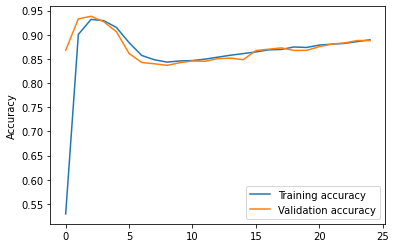

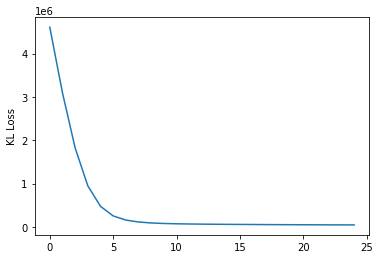

time: 14min 47s


In [23]:
# import random
#random.seed(2020)
if __name__ == '__main__':
    crit_t_statistic=2.262156 # t statistic with n-1 = 10-1 = 9 since pop. std. deviation unknown
    # for distribution-free confidence intervals:
    alpha = 5.0
    # calculate lower percentile (e.g. 2.5)
    lower_p = alpha / 2.0
    # calculate upper percentile (e.g. 97.5)
    upper_p = (100 - alpha) + (alpha / 2.0)

    parser = argparse.ArgumentParser(description = "PyTorch Bayesian Model Training")
    parser.add_argument('--net_type', default=net_type, type=str, help='model')
    parser.add_argument('-f')
    parser.add_argument('--dataset', default=dataset, type=str, help='dataset = [MNIST/CIFAR10/CIFAR100]')
    args = parser.parse_args()

    if cfg.record_mean_var:
        mean_var_dir = f"saved_model/{args.dataset}/bayesian/{args.net_type}/"
        cfg.mean_var_dir = mean_var_dir
        if not os.path.exists(mean_var_dir):
            os.makedirs(mean_var_dir, exist_ok=True)
        for file in os.listdir(mean_var_dir):
            os.remove(mean_var_dir + file)

    # return all training/validation metrics
    train_acc_list, valid_acc_list, train_loss_list, valid_loss_list, train_kl_list, net_trained, criterion, test_loader, n_epochs = run(args.dataset, args.net_type)
    print("----------------------------------Training done-------------------------------------------------")
    # return all test metrics
    test_loss, mean_test_accuracy, accuracies = test_model(net_trained, criterion, test_loader)
    
    print("Training accuracy is \t{}\n Validation accuracy is \t{}".format(train_acc_list[-1], valid_acc_list[-1]))
    print("TEST METRICS:")
    # standard deviation of test accuracies across the 10 sampled networks with VI
    sd_runs = np.std(accuracies)
    margin = crit_t_statistic*sd_runs/np.sqrt(10)
    # generalization gap b/w train and test, and train and valid
    train_test_gg = train_acc_list[-1]-mean_test_accuracy
    train_valid_gg = avg_diff_in_lists(train_acc_list[1:], valid_acc_list[1:])
    median_test_accuracy = median(accuracies)
    # retrieve observation at lower percentile
    lower = max(0.0, percentile(accuracies, lower_p))
    # retrieve observation at upper percentile
    upper = min(1.0, percentile(accuracies, upper_p))
    print("On average, the training-valid. generalization gap is \t{}\n After training, the training-test generalization gap is \t{}".format(train_valid_gg, train_test_gg))
    print("For a Bayesian {} CNN on the {} dataset with {} epochs, \nThe 95% confidence interval on mean test-set accuracy across 10 sampled sets of weights is \t{} +/- {}".format(net_type, dataset, N_EPOCHS,  mean_test_accuracy, margin))
    print("Median test accuracy is {}. The 95% dist'n-free confidence interval is ({},{})".format(median_test_accuracy, lower, upper))

    import matplotlib.pyplot as plt
    plt.plot(train_acc_list)
    plt.plot(valid_acc_list)
    plt.ylabel('Accuracy')
    plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')
    plt.show()


    import matplotlib.pyplot as plt
    plt.plot(train_kl_list)
    plt.ylabel('KL Loss')
    plt.show()





# For 5 epochs:


- Training accuracy is 	0.9198125

- Validation accuracy is 	0.9246666666666666

TEST METRICS:

- On average, the training-valid. generalization gap is 	-0.010432291666666649

- After training, the training-test generalization gap is 	-0.03156529552715648

For a Bayesian alexnet CNN on the MNIST dataset with 5 epochs, 
The 95% confidence interval on mean test-set accuracy across 10 sampled sets of weights is 	0.9513777955271565 +/- 0.03194795747099619
Median test accuracy is 0.96875. The 95% dist'n-free confidence interval is (0.84375,1.0)







# For 10 epochs:

- Training accuracy is 	0.8600208333333333

- Validation accuracy is 	0.86

TEST METRICS:

- On average, the training-valid. generalization gap is 	0.003798611111111103

- After training, the training-test generalization gap is 	-0.04153667465388711

For a Bayesian alexnet CNN on the MNIST dataset with 10 epochs, 
The 95% confidence interval on mean test-set accuracy across 10 sampled sets of weights is 	0.9015575079872205 +/- 0.04916489240667375
Median test accuracy is 0.90625. The 95% dist'n-free confidence interval is (0.74375,1.0)




# For 15 epochs:

- Training accuracy is 	0.8717916666666666
- Validation accuracy is 	0.8676666666666667

TEST METRICS:

- On average, the training-valid. generalization gap is 	-0.007035714285714288

- After training, the training-test generalization gap is 	0.016060835995740153

For a Bayesian alexnet CNN on the MNIST dataset with 15 epochs, 
The 95% confidence interval on mean test-set accuracy across 10 sampled sets of weights is 	0.8557308306709265 +/- 0.06177301143678058
Median test accuracy is 0.875. The 95% dist'n-free confidence interval is (0.65625,1.0)

# For 20 epochs:

- Training accuracy is 	0.884625

- Validation accuracy is 	0.886

TEST METRICS:

- On average, the training-valid. generalization gap is 	0.0018092105263157977

- After training, the training-test generalization gap is 	-0.01493570287539936

For a Bayesian alexnet CNN on the MNIST dataset with 20 epochs, 
The 95% confidence interval on mean test-set accuracy across 10 sampled sets of weights is 	0.8995607028753994 +/- 0.0495645849930956
Median test accuracy is 0.90625. The 95% dist'n-free confidence interval is (0.75,1.0)


# For 25 epochs:

- Training accuracy is 	0.8897083333333333

- Validation accuracy is 	0.8880833333333333

TEST METRICS:

- On average, the training-valid. generalization gap is 	0.002588541666666675

- After training, the training-test generalization gap is 	0.0019287806176783162

For a Bayesian alexnet CNN on the MNIST dataset with 25 epochs, 
The 95% confidence interval on mean test-set accuracy across 10 sampled sets of weights is 	0.887779552715655 +/- 0.055448479210460776
Median test accuracy is 0.90625. The 95% dist'n-free confidence interval is (0.71875,1.0)


